<a href="https://colab.research.google.com/github/marissadarnell/csc429/blob/main/Usable_copy_of_tree_based_ids_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles 
This is the code for the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, I. Hamieh and A. Shami, "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles," 2019 IEEE Global Communications Conference (GLOBECOM), 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9013892.  

## Import libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [5]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv')
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [10] if you work on the sampled dataset. 

In [6]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


Get the counts for each type of traffic that was labeled in the dataset:

In [7]:
df.Label.value_counts()

BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

### Data sampling
Due to the space limit of GitHub files, we sample a small-sized subset for model learning using random sampling

In [8]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [9]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [10]:
df_s = df_s.sort_index()

In [ ]:
# Save the sampled dataset
df_s.to_csv('./data/CICIDS2017_sample.csv',index=0)

### Preprocessing (normalization and padding values)

In [11]:
df = pd.read_csv('./data/CICIDS2017_sample.csv')

In [12]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [13]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [14]:
X_train.shape

(45328, 77)

In [15]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [17]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9956763434218654
Precision of DT: 0.9956631875109845
Recall of DT: 0.9956763434218654
F1-score of DT: 0.9956635393580726
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



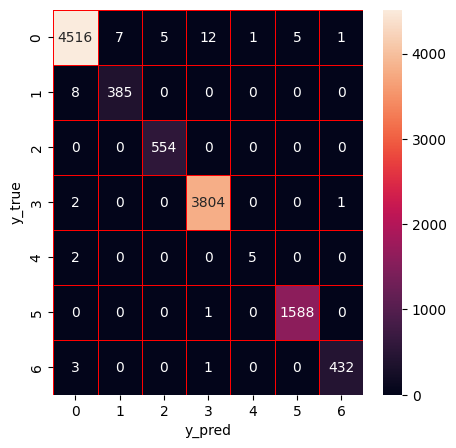

In [19]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [20]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9959410570899144
Precision of RF: 0.9959403334272374
Recall of RF: 0.9959410570899144
F1-score of RF: 0.9959160105868221
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



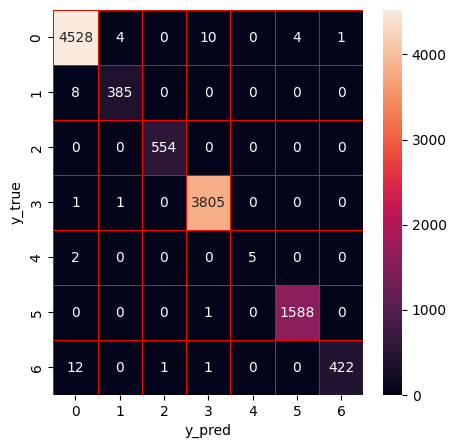

In [21]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [22]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.992676255183976
Precision of ET: 0.99269179480266
Recall of ET: 0.992676255183976
F1-score of ET: 0.9926600348908537
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.98      0.97       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



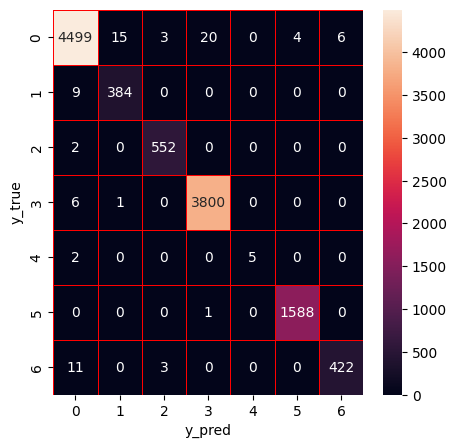

In [23]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [24]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9947939645283684
Precision of XGBoost: 0.994783334508082
Recall of XGBoost: 0.9947939645283684
F1-score of XGBoost: 0.9947770765700757
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



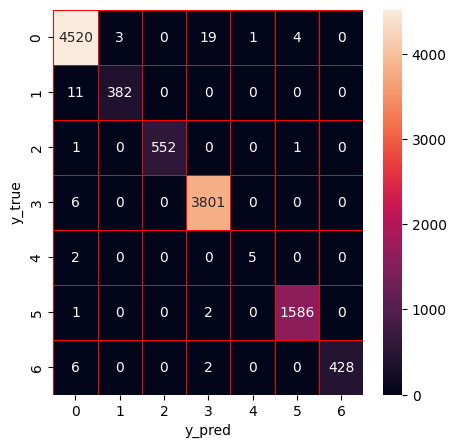

In [25]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [26]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [27]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [28]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [29]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [30]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9956763434218654
Precision of Stacking: 0.9956786965937533
Recall of Stacking: 0.9956763434218654
F1-score of Stacking: 0.9956592364077332
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



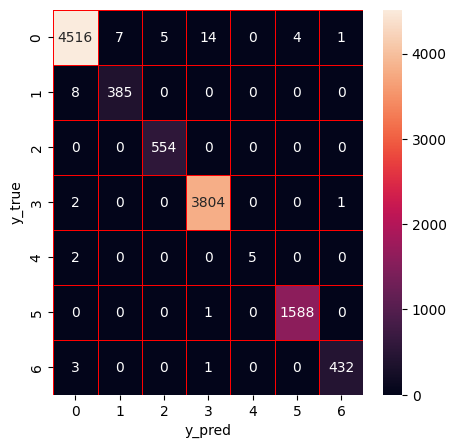

In [31]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [ ]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [ ]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [ ]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.1235, 'Bwd Packet Length Std'), (0.0853, 'Bwd Packet Length Min'), (0.0574, 'Average Packet Size'), (0.05, 'Init_Win_bytes_backward'), (0.0492, 'Bwd Packet Length Mean'), (0.0401, 'Init_Win_bytes_forward'), (0.0397, 'PSH Flag Count'), (0.038, 'Bwd Packets/s'), (0.034, 'Bwd Header Length'), (0.028, 'Avg Bwd Segment Size'), (0.0264, 'Packet Length Mean'), (0.0235, 'Packet Length Variance'), (0.0228, 'Fwd Header Length'), (0.0209, 'Bwd Packet Length Max'), (0.0193, 'min_seg_size_forward'), (0.0182, 'ACK Flag Count'), (0.017, 'act_data_pkt_fwd'), (0.0157, 'Fwd Header Length.1'), (0.0128, 'Packet Length Std'), (0.0122, 'Total Length of Fwd Packets'), (0.0117, 'Fwd PSH Flags'), (0.0108, 'Fwd Packet Length Max'), (0.0108, 'Fwd IAT Mean'), (0.0106, 'Total Fwd Packets'), (0.0106, 'Flow IAT Max'), (0.01, 'Subflow Fwd Bytes'), (0.0095, 'Fwd IAT Max'), (0.0094, 'Subflow Bwd Bytes'), (0.0094, 'Max Packet Length'), (0.0092, 'Subflow Bwd Packets'), (0.009, 'Min Pac

In [ ]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [ ]:
len(f_list)

77

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [ ]:
X_fs = df[fs].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(45328, 38)

In [ ]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

### Oversampling by SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.9959410570899144
Precision of DT: 0.9959421882780577
Recall of DT: 0.9959410570899144
F1-score of DT: 0.995922941273118
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



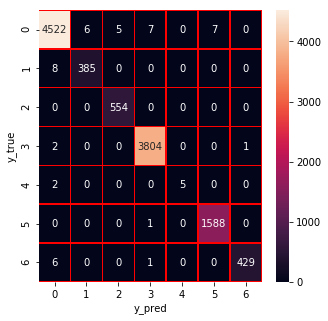

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9963822465366629
Precision of RF: 0.9963638997836398
Recall of RF: 0.9963822465366629
F1-score of RF: 0.9963668543569548
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



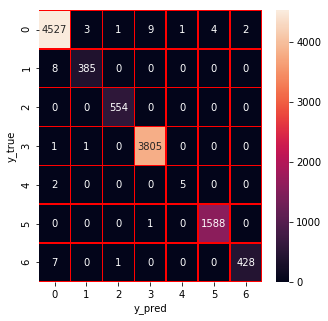

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
# learning of the model on the data is done with the fit function
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.995764581311215
Precision of ET: 0.9957533838731291
Recall of ET: 0.995764581311215
F1-score of ET: 0.9957536562646003
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.97      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



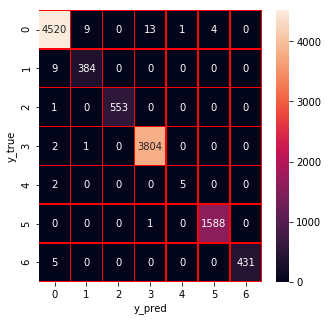

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.9945292508603194
Precision of XGBoost: 0.9945034026564313
Recall of XGBoost: 0.9945292508603194
F1-score of XGBoost: 0.9944940662484604
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       1.00      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.80      0.57      0.67         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.93      0.95     11333
weighted avg       0.99      0.99      0.99     11333



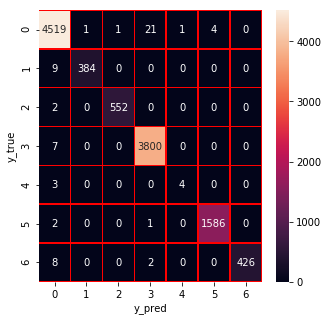

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,ExtraTrees,RandomForest,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9955881055325156
Precision of Stacking: 0.9955944258266153
Recall of Stacking: 0.9955881055325156
F1-score of Stacking: 0.9955625491897051
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       1.00      0.97      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       0.99      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



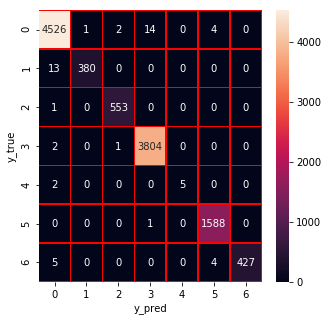

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()